In [4]:
import os
import tensorflow as tf
DATA_DIR = "D:\Smart parking\Data\PKLot\PKLotSegm_sample"

def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR, image_size=(54,32), batch_size=16, validation_split=0.2,
    subset="training", seed=123, 
)
train_data = train_data.map(process)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR, image_size=(54,32), batch_size=16, validation_split=0.2,
    subset="validation", seed=123, 
)
test_data = test_data.map(process)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from keras.regularizers import l2

"""
Carnet model implementation based on paper:
"Generalized Parking Occupancy Analysis Based on Dilated Convolutional Neural Network"
"""

model = Sequential(name="Carnet")
WEIGHT_DECAY = 0.0005
regularizer = l2(WEIGHT_DECAY)

#Conv1
model.add(Conv2D(96, kernel_size=(11, 11), dilation_rate=2, activation='relu',
                 input_shape=(54, 32, 3), padding='same', kernel_regularizer=regularizer))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

#Conv2
model.add(Conv2D(192, kernel_size=(11,11), dilation_rate=2, activation='relu',
                 padding='same', kernel_regularizer=regularizer))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Conv3
model.add(Conv2D(384, kernel_size=(11, 11), dilation_rate=2, activation='relu',
                 padding='same', kernel_regularizer=regularizer))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten
model.add(Flatten())

#FC1
model.add(Dense(4096, activation='relu',
                kernel_regularizer=regularizer))
model.add(Dropout(.2))

#FC2
model.add(Dense(4096, activation='relu',
                kernel_regularizer=regularizer))
model.add(Dropout(.2))

#Output
model.add(Dense(1, activation='sigmoid'))

opt = SGD(learning_rate=0.00001,
          momentum=0.99)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])

print(model.summary())

Model: "Carnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 54, 32, 96)        34944     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 16, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 16, 192)       2230464   
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 8, 192)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 8, 384)        8921472   
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 4, 384)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0    

In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
with tf.device('/GPU:0'):
    model.fit(train_data, batch_size=16, epochs=150)

Epoch 1/150
500/500 [==============================] - 21s 41ms/step - loss: 5.7539 - accuracy: 0.7805
Epoch 2/150
500/500 [==============================] - 21s 41ms/step - loss: 5.7333 - accuracy: 0.8798
Epoch 3/150
500/500 [==============================] - 21s 41ms/step - loss: 5.6932 - accuracy: 0.9121
Epoch 4/150
500/500 [==============================] - 21s 41ms/step - loss: 5.5867 - accuracy: 0.9256
Epoch 5/150
500/500 [==============================] - 21s 41ms/step - loss: 5.3538 - accuracy: 0.9421
Epoch 6/150
500/500 [==============================] - 21s 41ms/step - loss: 5.1966 - accuracy: 0.9626
Epoch 7/150
500/500 [==============================] - 21s 41ms/step - loss: 5.1478 - accuracy: 0.9709
Epoch 8/150
500/500 [==============================] - 21s 41ms/step - loss: 5.1488 - accuracy: 0.9649
Epoch 9/150
500/500 [==============================] - 21s 42ms/step - loss: 5.1321 - accuracy: 0.9690
Epoch 10/150
500/500 [==============================] - 21s 42ms/step - l

In [15]:
scores = model.evaluate(test_data, verbose=1)

125/125 [==============================] - 2s 12ms/step - loss: 4.3926 - accuracy: 0.9930


In [13]:
y_pred

array([[1.1851066e-04],
       [9.9996769e-01],
       [3.9419390e-02],
       ...,
       [9.5173233e-04],
       [9.9996424e-01],
       [9.9999762e-01]], dtype=float32)

In [16]:
type(test_data)

tensorflow.python.data.ops.dataset_ops.MapDataset

tf.Tensor(
[[[0.47898284 0.52996325 0.31819853]
  [0.48400736 0.53498775 0.32322302]
  [0.48903185 0.54001224 0.32824755]
  ...
  [0.48860294 0.5148897  0.39362746]
  [0.5122549  0.5335172  0.440625  ]
  [0.6771446  0.70349264 0.6374387 ]]

 [[0.47026142 0.52124184 0.30947712]
  [0.47790712 0.5288875  0.31712282]
  [0.48507625 0.53605664 0.32429194]
  ...
  [0.4733524  0.49963918 0.3744213 ]
  [0.49876767 0.52002996 0.42280093]
  [0.65970176 0.6860498  0.61432457]]

 [[0.46283132 0.50887346 0.29217046]
  [0.4722676  0.51726806 0.30369008]
  [0.47974086 0.5233138  0.31401825]
  ...
  [0.45691946 0.49061367 0.3568582 ]
  [0.47334787 0.503445   0.39614198]
  [0.63002676 0.6598856  0.57454157]]

 ...

 [[0.8421795  0.8475262  0.841948  ]
  [0.819079   0.8269221  0.8167869 ]
  [0.7559118  0.76896334 0.74908537]
  ...
  [0.6804421  0.6922068  0.62002546]
  [0.6506446  0.6624093  0.59574264]
  [0.60350865 0.61190325 0.55871695]]

 [[0.8132079  0.8149373  0.80405074]
  [0.79658216 0.8039215  0

c:\Users\Usuario\Documents\proyectos\smart_parking\carnet\.venv\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


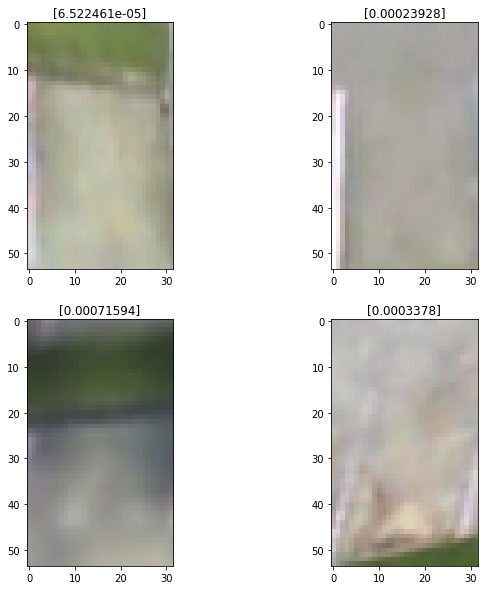

In [82]:
from matplotlib import pyplot as plt
import numpy as np
plt.figure(figsize=(10,10))

for x, y in test_data.take(1):
    y_pred = model.predict(x[:4,:],verbose=0)
    plt.subplot(221)
    print(x[0])
    print(np.squeeze(x[0]).shape)
    plt.imshow(np.squeeze(x[0]))
    plt.title(y_pred[0])
    plt.subplot(222)
    plt.imshow(np.squeeze(x[1]))
    plt.title(y_pred[1])
    plt.subplot(223)
    plt.imshow(np.squeeze(x[2]))
    plt.title(y_pred[2])
    plt.subplot(224)
    plt.imshow(np.squeeze(x[3]))
    plt.title(y_pred[3])
plt.show()

In [48]:
model.save('Carnet.h5')

In [50]:
import tensorflow as tf
tf.__version__

'2.6.2'

In [18]:
import tensorflow as tf
model = tf.keras.models.load_model('Carnet_transfer.h5')

In [19]:
import tensorflow as tf
import numpy as np

img = tf.keras.utils.load_img('1803.jpg', target_size=(54,32))
input_arr = tf.keras.utils.img_to_array(img)
input_arr = np.array([input_arr]) 
input_arr = input_arr/255

In [20]:
np.squeeze(input_arr).shape

(54, 32, 3)

array([[0.01636452]], dtype=float32)

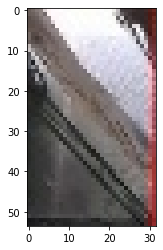

In [21]:
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(np.squeeze(input_arr))
model.predict(input_arr)

# Evaluate with Marko Data

In [226]:
DATA_DIR = "D:\Smart parking\Data\Data_Marko_cropped"
marko_data = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR, image_size=(54,32), batch_size=1, seed=123
)
marko_data = marko_data.map(process)

Found 2088 files belonging to 2 classes.


In [223]:
scores = model.evaluate(marko_data, verbose=1)

66/66 [==============================] - 1s 17ms/step - loss: 5.3808 - accuracy: 0.8127


In [ ]:
scores = model.evaluate(marko_data, verbose=1)

66/66 [==============================] - 1s 17ms/step - loss: 5.3808 - accuracy: 0.8127


In [227]:
import numpy as np
x_marko = []
y_marko =  []
for x,y in marko_data:
    x = np.array(x).squeeze()
    x_marko.append(x)
    y_marko.append(y)
x_marko = np.array(x_marko)
y_marko = np.array(y_marko)
x_marko.shape

(2088, 54, 32, 3)

In [229]:
y_pred = model.predict(x_marko)

In [230]:
y_classes = y_pred
y_classes[np.where(y_pred>=0.5)] = 1
y_classes[np.where(y_pred<0.5)] = 0
y_classes = np.array(y_classes, dtype = int)

In [231]:
y_classes.squeeze()

array([1, 1, 1, ..., 0, 1, 1])

In [232]:
len(y_marko)

2088

In [233]:
from sklearn.metrics import confusion_matrix
result = confusion_matrix(y_marko, y_classes , normalize='pred')
result

array([[1.        , 0.22190692],
       [0.        , 0.77809308]])

# Transfer Learning

In [2]:
import tensorflow as tf
transfer_model = tf.keras.models.load_model('Carnet.h5')

In [9]:
transfer_model.summary()

Model: "Carnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 54, 32, 96)        34944     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 16, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 16, 192)       2230464   
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 8, 192)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 8, 384)        8921472   
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 4, 384)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0    

In [10]:
for layer in transfer_model.layers:
    print(layer)

In [3]:
for layer in transfer_model.layers[0:5:2]:
    layer.trainable = False

In [12]:
transfer_model.summary()

Model: "Carnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 54, 32, 96)        34944     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 16, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 16, 192)       2230464   
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 8, 192)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 8, 384)        8921472   
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 4, 384)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0    

In [8]:
DATA_DIR = "D:\Smart parking\Data\CTIC_Parking_dataset"
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label
data_train = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR, image_size=(54,32), batch_size=16, seed=123, validation_split = 0.2, subset="training"
)
data_train = data_train.map(process)

data_test = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR, image_size=(54,32), batch_size=16, seed=123, validation_split = 0.2, subset="validation"
)
data_test = data_test.map(process)

In [9]:
with tf.device('/GPU:0'):
    transfer_model.fit(data_train, batch_size=16, epochs=500)

Epoch 1/500
150/150 [==============================] - 22s 126ms/step - loss: 4.6802 - accuracy: 0.9041
Epoch 2/500
150/150 [==============================] - 24s 159ms/step - loss: 4.5028 - accuracy: 0.9544
Epoch 3/500
150/150 [==============================] - 31s 207ms/step - loss: 4.4599 - accuracy: 0.9732
Epoch 4/500
150/150 [==============================] - 41s 277ms/step - loss: 4.4479 - accuracy: 0.9774
Epoch 5/500
150/150 [==============================] - 33s 223ms/step - loss: 4.4422 - accuracy: 0.9786
Epoch 6/500
150/150 [==============================] - 45s 300ms/step - loss: 4.4321 - accuracy: 0.9824
Epoch 7/500
150/150 [==============================] - 50s 337ms/step - loss: 4.4282 - accuracy: 0.9816
Epoch 8/500
150/150 [==============================] - 47s 316ms/step - loss: 4.4250 - accuracy: 0.9841
Epoch 9/500
150/150 [==============================] - 44s 295ms/step - loss: 4.4197 - accuracy: 0.9874
Epoch 10/500
150/150 [==============================] - 47s 316m

In [10]:
scores = transfer_model.evaluate(data_test, verbose=1)

38/38 [==============================] - 5s 75ms/step - loss: 3.8396 - accuracy: 0.9815


In [11]:
transfer_model.save('Carnet_transfer.h5')

# Evaluate transfer model

In [252]:
DATA_DIR = "D:\Smart parking\Data\Data_Marko_cropped"
marko_data = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR, image_size=(54,32), batch_size=1, seed=123
)
marko_data = marko_data.map(process)

Found 2088 files belonging to 2 classes.


In [253]:
scores = transfer_model.evaluate(marko_data, verbose=1)

2088/2088 [==============================] - 20s 10ms/step - loss: 3.9467 - accuracy: 0.9966


In [254]:
import numpy as np
x_marko = []
y_marko =  []
for x,y in marko_data:
    x = np.array(x).squeeze()
    x_marko.append(x)
    y_marko.append(y)
x_marko = np.array(x_marko)
y_marko = np.array(y_marko)
x_marko.shape

(2088, 54, 32, 3)

In [255]:
y_pred = transfer_model.predict(x_marko)

In [256]:
y_classes = y_pred
y_classes[np.where(y_pred>=0.5)] = 1
y_classes[np.where(y_pred<0.5)] = 0
y_classes = np.array(y_classes, dtype = int)

In [257]:
y_classes.squeeze()

array([1, 1, 1, ..., 1, 1, 1])

In [258]:
len(y_marko)

2088

In [259]:
from sklearn.metrics import confusion_matrix
result = confusion_matrix(y_marko, y_classes , normalize='pred')
result

array([[0.99305556, 0.00146199],
       [0.00694444, 0.99853801]])

(54, 32, 3)
(54, 32, 3)
(54, 32, 3)
(54, 32, 3)


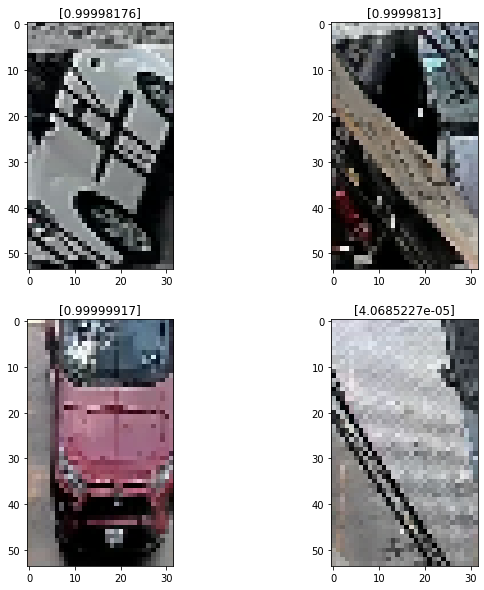

In [512]:
from matplotlib import pyplot as plt
import numpy as np
np.random.shuffle(x_marko)
sample = x_marko[:4]
plt.figure(figsize=(10,10))
i = 0
y_pred = transfer_model.predict(sample,verbose=0)
for x in sample:
    print(x.shape)
    plt.subplot(221+i)
    plt.imshow(np.squeeze(x))
    plt.title(y_pred[i])
    i+=1
    
plt.show()